## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [25]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

In [12]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [13]:
df= df.dropna()


In [34]:
df_numerics = df.select_dtypes(include = np.number, exclude = object)

In [35]:
df_numerics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15762 entries, 1 to 21596
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15762 non-null  int64  
 1   price          15762 non-null  float64
 2   bedrooms       15762 non-null  int64  
 3   bathrooms      15762 non-null  float64
 4   sqft_living    15762 non-null  int64  
 5   sqft_lot       15762 non-null  int64  
 6   floors         15762 non-null  float64
 7   sqft_above     15762 non-null  int64  
 8   yr_built       15762 non-null  int64  
 9   yr_renovated   15762 non-null  float64
 10  zipcode        15762 non-null  int64  
 11  lat            15762 non-null  float64
 12  long           15762 non-null  float64
 13  sqft_living15  15762 non-null  int64  
 14  sqft_lot15     15762 non-null  int64  
dtypes: float64(6), int64(9)
memory usage: 1.9 MB


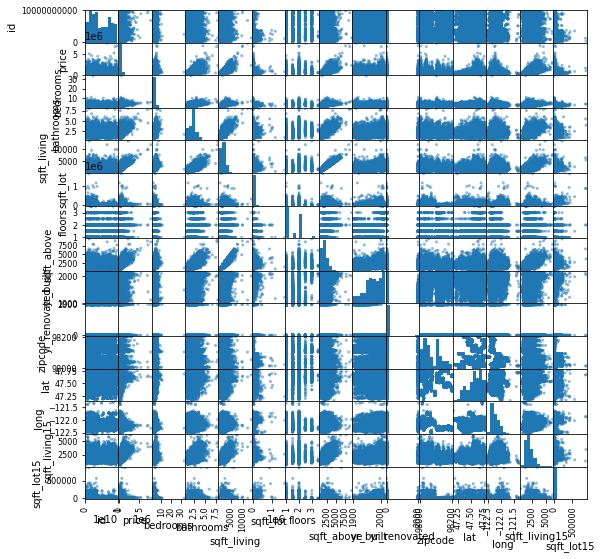

In [24]:
# use pd.plotting.scatter_matrix
pd.plotting.scatter_matrix(df_numerics,figsize  = [9, 9]);

In [26]:
y = df_numerics['price']
x = sm.add_constant(df_numerics.drop(columns='price'))

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
model = sm.OLS(y,x).fit()

<AxesSubplot:>

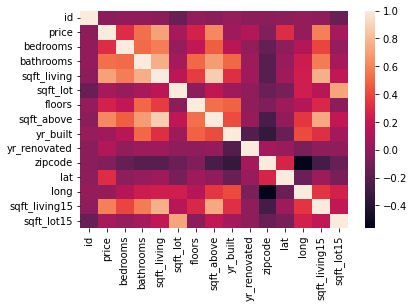

In [38]:
import seaborn as sns

Var_Corr = df_numerics.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False)

In [50]:
df_numerics.columns[0]

'id'

IndexError: single positional indexer is out-of-bounds

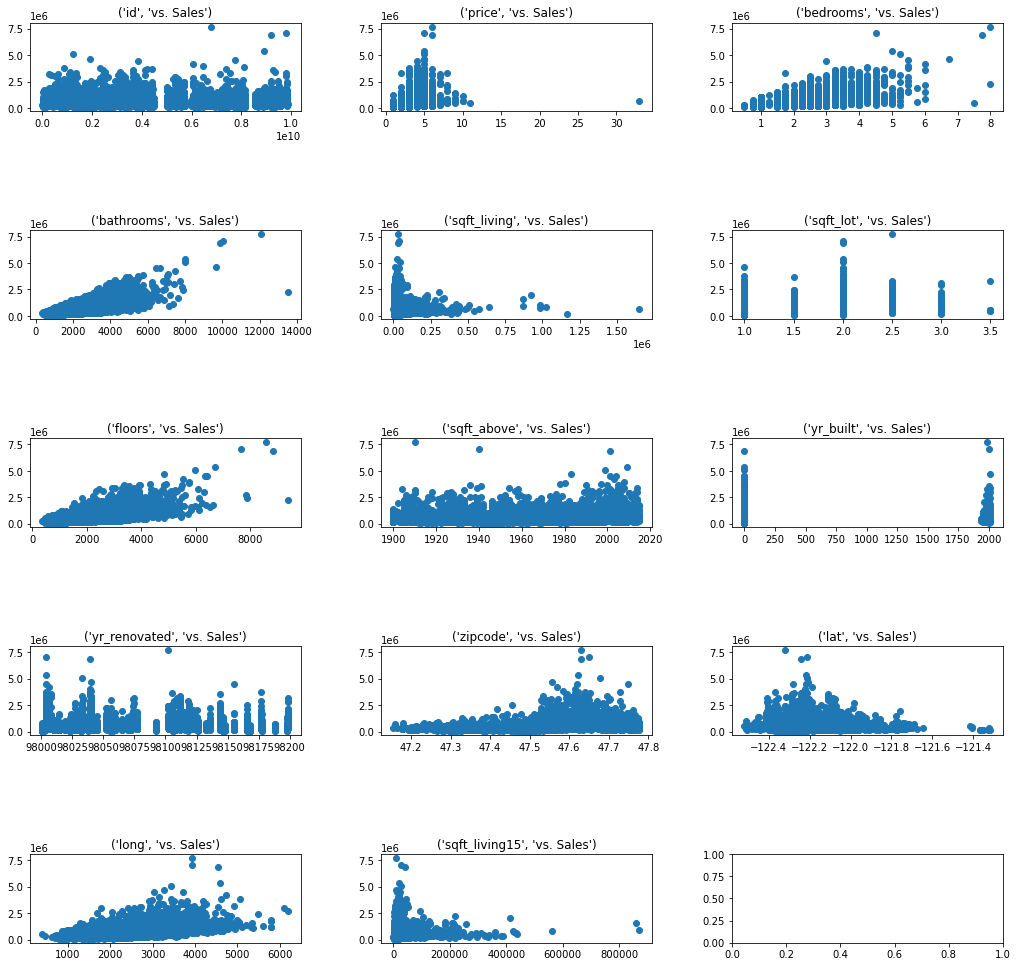

In [58]:
fig, axs = plt.subplots(5,3)
plt.tight_layout()

fig.set_figheight(15)
fig.set_figwidth(15)

independants = df_numerics.drop(columns='price')
dependant = df_numerics['price']
column_num = 0

for i in range(5):
    for j in range(3):
        axs[i,j].scatter(independants.iloc[:,column_num],dependant)
        axs[i,j].set_title((df_numerics.columns[column_num],'vs. Sales'))
        column_num += 1